# The thinking behind this code
I'd like to get a feel for how ARIMA models can be used for anomaly/outlier detection in my battery temperature data. The basic idea is to train the ARIMA model on the time series data to learn what's "normal" for the data, then forecast the data with that model, and any point that differs greatly from the model's predictions can be called an outlier. Defining "differs greatly" is a complicated problem that will be swept under the rug here — I'll naively say anything that differs more than a standard deviation is an outlier.

In [2]:
import datetime
import pandas as pd
from pandas import datetime
from pandas import read_csv
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error


## First thing's first: load the Battery Temperature data into a pandas Series

count    128288.000000
mean          3.882216
std           3.028609
min          -8.822058
25%           1.709975
50%           2.927961
75%           5.216317
max          23.116580
Name: 3.8320112373931594, dtype: float64


2004-02-13 15:00:00
2004-02-13 16:00:00    3.382078
2004-02-13 17:00:00    3.848675
2004-02-13 18:00:00    3.645655
2004-02-13 19:00:00    3.542035
2004-02-13 20:00:00    3.782337
Name: 3.8320112373931594, dtype: float64


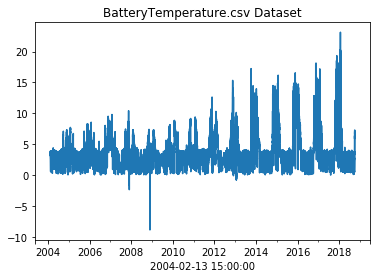

In [3]:
def parser(x):
    new_time = ''.join(x.split('.')[0])  # remove microseconds
    return datetime.strptime(new_time, '%Y-%m-%d %H:%M:%S') 


# Load the dataset
dataset_path = 'Data/BatteryTemperature.csv'
time_series = read_csv(dataset_path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

print(time_series.describe())
print('\n')
print(time_series.head())
time_series.plot(title=dataset_path.split('/')[-1] + ' Dataset')  # plots the data
pyplot.show()

This is a fairly large dataset, and I want to speed up compute times for this notebook, so I'll only use a subset of the data, and I'll take the daily averages of that subset:

count    2557.000000
mean        3.669464
std         2.570195
min        -3.169324
25%         1.993779
50%         2.478634
75%         5.053053
max        13.836743
Name: 3.8320112373931594, dtype: float64


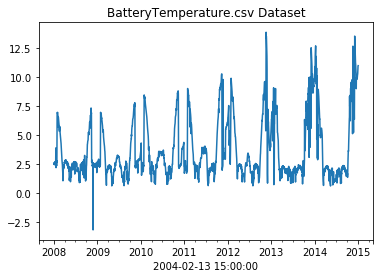

In [4]:
time_series = time_series.loc['2008':'2014']
time_series = time_series.resample('24H').mean()
print(time_series.describe())
time_series.plot(title=dataset_path.split('/')[-1] + ' Dataset')  # plots the data
pyplot.show()

Just by visually inspecting this time series, a handful of sudden spikes appear anomalous. But let's see what the model thinks.

## Next, let's view ACF and PACF plots for this data to get an idea for good hyperparameters. Then we'll fit an ARIMA model to the data:

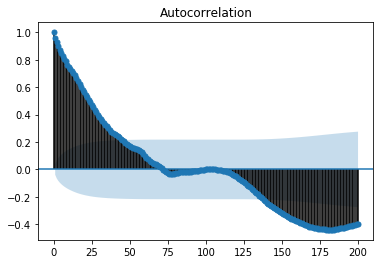

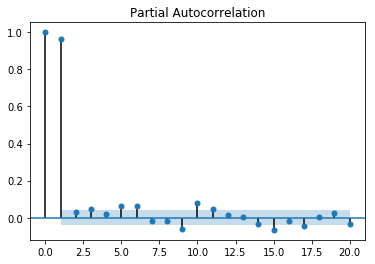

In [5]:
plot_acf(time_series, lags=200)
pyplot.show()

plot_pacf(time_series, lags=20)
pyplot.show()

**Note:** I'm about to construct an `ARIMA(p,d,q)(P,D,Q)m` model. I've read that `p` and `q` values can be infered by:

`p`: The lag value where the PACF chart crosses the upper confidence interval for the first time.

`q`: The lag value where the ACF chart crosses the upper confidence interval for the first time.

But I need to confirm this. I still don't totally understand it.

In [6]:
X = time_series
threshold = float(X.values.std(ddof=0))  # anything that differs more than 1std is an outlier

trained_model = SARIMAX(X, order=(2,0,0), seasonal_order=(0,1,0,365))

Before I fit this `ARIMA(2,0,0)(0,1,0)365` model, let's mark the current time to see how long training takes. 

In [7]:
current_time = str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Before fitting: ' + current_time)

trained_model_fit = trained_model.fit(disp=1)  # fits the model

current_time = str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('After fitting: ' + current_time)

Before fitting: 2019-03-08 15:04:35
After fitting: 2019-03-08 15:09:03


It looks like fitting took roughly 5 minutes.

## So now we've trained the ARIMA model. Let's use it to forecast and label outliers:

First I'll plot the residual errors from training. Then I'll get the model's predictions, check which points in the dataset differ more than a standard deviation from the predictions, and plot the results.

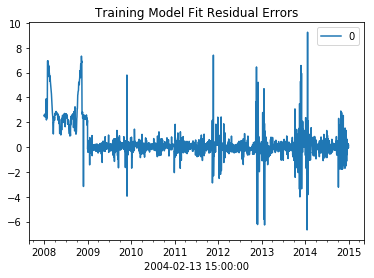

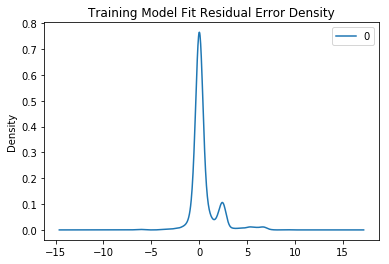

                 0
count  2557.000000
mean      0.446503
std       1.371849
min      -6.665723
25%      -0.150321
50%       0.084809
75%       0.436976
max       9.243017


MSE: 2.079
Detected outliers: 189



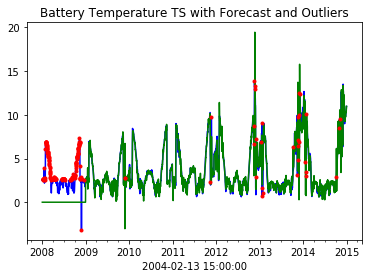

In [8]:
# Plot residual errors
residuals = pd.DataFrame(trained_model_fit.resid)
residuals.plot(title='Training Model Fit Residual Errors')
pyplot.show()
residuals.plot(kind='kde', title='Training Model Fit Residual Error Density')
pyplot.show()
print(residuals.describe())
print('\n')

# Forecast with the trained ARIMA model
predictions = trained_model_fit.predict(start=1, end=len(X)-1, typ='levels')
predict_index = pd.Index(X.index[1:len(X)])
predictions_with_dates = pd.Series(predictions.values, index=predict_index)
outliers = pd.Series()
time_series_with_outliers = pd.DataFrame({'Temperature': X})
time_series_with_outliers['Outlier'] = 'False'

# Label outliers using the forecast
for t in range(len(X)-1):
    obs = X[t+1]
    yhat = predictions_with_dates[X.index[t+1]]
    #print('predicted=%f, expected=%f' % (yhat, obs))
    if abs(yhat - obs) > threshold:
        time_series_with_outliers.at[time_series.index[t+1], 'Outlier'] = 'True'
        outlier = pd.Series(obs, index=[X.index[t+1]])
        outliers = outliers.append(outlier)

# Calculte MSE
model_error = mean_squared_error(X[1:len(X)], predictions_with_dates)
print('MSE: %.3f' % model_error)

# Plot the forecast and outliers
X.plot(color='blue', title='Battery Temperature TS with Forecast and Outliers')
predictions_with_dates.plot(color='green')
if len(outliers) > 0:
    print('Detected outliers: ' + str(len(outliers)) + '\n')
    outliers.plot(color='red', style='.')
pyplot.show()


## One last plot, this time with just the original data and the outliers, for clarity:


Detected outliers: 189



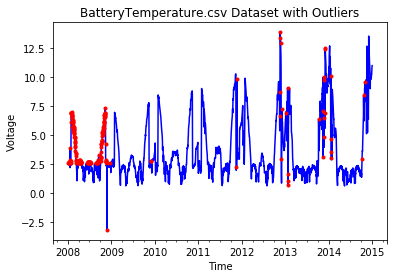

In [9]:
# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('Voltage')
if len(outliers) > 0:
    print('\nDetected outliers: ' + str(len(outliers)) + '\n')
    outliers.plot(color='red', style='.')
pyplot.show()

## The plot above has labeled outliers in the time series data, marked in red, but there are not many. Perhaps the model overfit? The first seasonal period is all red because there were no predictions there.